In [75]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simulating the Maxwell-Boltzmann Distribution with `torch`

In this notebook, we will simulate the collision of classical free particles in a box and demonstrate how the distribution of their velocities converges to a **Maxwell-Boltzman distribution**. In order to simulate smoothly thousands of particles we will exploit the computation powers provided by the `torch` package, a popular Python package in the Deep Learning community which allows performing tensor computations with strong **GPU** acceleration. 

Before we jump into coding our particle simulation, we'll take a quick look at the basics of `torch`, comparing it to common operations in `numpy`. Then, we'll get into the theory behind the Maxwell-Boltzmann distribution. Finally, we'll whip up an animated gif to visualize the simulation of thousands of particles bouncing around, showing how their velocity distribution evolves over time.

## An introduction to Torch and comparison with Numpy

The building blocks of the `torch` package are the so-called **tensor** object. A tensor is a mathemtical object with specific properties and there is whole branch of maths dealing with this kind of entities (*tensor algebra* and *differential geometry*). However, for the purpose of this notebook, we could consider a tensor merely as a multi-dimensional extension of the concept of vector and matrix. Indeed, a vector can be informally defined as an object whose components depend on a single index $i$ (e.g. $v_i$); a matrix is specified by components depending on two indices, $i,j$, which define rows and columns. A tensor is a set of components depending on more than 2 indices. 

From a computational point of view, torch tensors are closely resembles `numpy` arrays and so they can be manipulated in a very similar manner. There is one major difference between torch tensors and numpy array that we will discuss shortly below. Let's now see how we can work with torch tensors and let's look at the major methods provided by the package:

In [10]:
# We define a 1D tensor, using linspace, similar to numpy.linspace
t = torch.linspace(0,1000, 50)

In [11]:
t

tensor([   0.0000,   20.4082,   40.8163,   61.2245,   81.6327,  102.0408,
         122.4490,  142.8571,  163.2653,  183.6735,  204.0816,  224.4898,
         244.8979,  265.3061,  285.7143,  306.1224,  326.5306,  346.9388,
         367.3469,  387.7551,  408.1633,  428.5714,  448.9796,  469.3878,
         489.7959,  510.2041,  530.6122,  551.0204,  571.4286,  591.8367,
         612.2449,  632.6531,  653.0612,  673.4694,  693.8776,  714.2857,
         734.6939,  755.1021,  775.5102,  795.9184,  816.3265,  836.7347,
         857.1429,  877.5510,  897.9592,  918.3674,  938.7755,  959.1837,
         979.5919, 1000.0000])

In [13]:
# We can print the shape of the tensor as follows -> below we have a 1D vector of size 50
t.shape

torch.Size([50])

In [20]:
# Similarly we can defined a 2D tensor, i.e. a NxN matrix. 
t_2d = torch.rand(5, 2)

In [21]:
t_2d

tensor([[9.9746e-01, 4.0948e-05],
        [4.8764e-01, 7.1584e-01],
        [3.0321e-01, 8.2252e-01],
        [7.8318e-01, 5.0858e-01],
        [9.9661e-01, 3.0936e-01]])

In [22]:
t_2d.shape

torch.Size([5, 2])

Above, we have defined a 5x2 matrix using the `rand` method and passing two integers values, respectively specifying the number of rows and column. The method draws $N$ random numbers uniformely distributed in $[0,1]$ for both rows and columns. We can subset the matrix and extract rows or columns as we do with numpy arrays:

In [23]:
# the first row
t_2d[0,:]

tensor([9.9746e-01, 4.0948e-05])

In [24]:
# the first column
t_2d[:,0]

tensor([0.9975, 0.4876, 0.3032, 0.7832, 0.9966])

In [26]:
# Suppose that we want to subset just those elements in the first row where the value is higher than 0.1
t_2d[0]>0.1

tensor([ True, False])

In [30]:
t_2d[0, t_2d[0]>0.1], t_2d[0][t_2d[0]>0.1]

(tensor([0.9975]), tensor([0.9975]))

Notice that there two equivalent ways of subsetting. We can use both: `t_2d[0,t_2d[0]>0.1]`and `t_2d[0][t_2d[0]>0.1]`.

### Tensor Algebra with `torch`

Let now perform some basic algebric operations with torch and let compare with numpy!

In [34]:
# sum of tensors
t1 = torch.rand(10)
t2 = torch.rand(10)

In [35]:
t1, t2

(tensor([0.9634, 0.4651, 0.1023, 0.5326, 0.6344, 0.1717, 0.9388, 0.8364, 0.4451,
         0.6478]),
 tensor([0.4966, 0.6882, 0.0115, 0.5205, 0.9248, 0.4605, 0.8196, 0.8720, 0.1942,
         0.0167]))

In [36]:
t1+t2

tensor([1.4600, 1.1533, 0.1138, 1.0531, 1.5593, 0.6322, 1.7584, 1.7084, 0.6393,
        0.6645])

In [38]:
# product by a scalar
n = 2
t1*n

tensor([1.9268, 0.9302, 0.2046, 1.0652, 1.2688, 0.3435, 1.8776, 1.6727, 0.8902,
        1.2955])

In [40]:
# product of 1D tensors 
t1*t2, (t1*t2).shape

(tensor([0.4784, 0.3201, 0.0012, 0.2772, 0.5867, 0.0791, 0.7694, 0.7293, 0.0864,
         0.0108]),
 torch.Size([10]))

In [67]:
# Let perform now a matrix multiplication
t1_2d = torch.arange(1000).reshape(100,10)
t2_2d = torch.arange(500).reshape(10,50)

To multiply matrix $(i,j)$ times a matrix $(j,k)$, we can use the `.mm` method:

In [69]:
matrix_prod = torch.mm(t1_2d, t2_2d)

In [70]:
matrix_prod

tensor([[  14250,   14295,   14340,  ...,   16365,   16410,   16455],
        [  36750,   36895,   37040,  ...,   43565,   43710,   43855],
        [  59250,   59495,   59740,  ...,   70765,   71010,   71255],
        ...,
        [2196750, 2206495, 2216240,  ..., 2654765, 2664510, 2674255],
        [2219250, 2229095, 2238940,  ..., 2681965, 2691810, 2701655],
        [2241750, 2251695, 2261640,  ..., 2709165, 2719110, 2729055]])

In [71]:
matrix_prod.shape

torch.Size([100, 50])

In [72]:
# Let do the same in numpy
arr1_2d = np.arange(1000).reshape(100,10)
arr2_2d = np.arange(500).reshape(10,50)

In [73]:
arr1_2d@arr2_2d

array([[  14250,   14295,   14340, ...,   16365,   16410,   16455],
       [  36750,   36895,   37040, ...,   43565,   43710,   43855],
       [  59250,   59495,   59740, ...,   70765,   71010,   71255],
       ...,
       [2196750, 2206495, 2216240, ..., 2654765, 2664510, 2674255],
       [2219250, 2229095, 2238940, ..., 2681965, 2691810, 2701655],
       [2241750, 2251695, 2261640, ..., 2709165, 2719110, 2729055]])

Let now compare the performance of torch and numpy multiplying big matrices.  We wil introduce another method called `.to(device)` to move tensor computation on CUDA GPU if available. The piece of code written at the beginning:

`device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`

checks if CUDA (GPU support) is available on the system. If CUDA is available, it assigns the device to the GPU ('cuda'), otherwise, it assigns it to the CPU ('cpu'). This line ensures that the code can run on both GPU-enabled and CPU-only systems without modification.

In [123]:
r, c = 10000, 10000

# "standard" torch
t1 = torch.rand(r,c)
t2 = torch.rand(c, r)

# cuda torch
t1_cuda = torch.rand(r,c).to(device)
t2_cuda = torch.rand(c, r).to(device)

np1 = np.random.rand(r,c)
np2 = np.random.rand(c,r)

In [124]:
start = time.time()
torch.mm(t1, t2)
execution_time_torch = time.time()-start

start = time.time()
torch.mm(t1_cuda, t2_cuda)
execution_time_torch_cuda = time.time()-start

start = time.time()
np.matmul(np1, np2)
execution_time_numpy = time.time()-start


print(f"Computaton time to multiply ({r},{c})x({c},{r}) with Torch: {execution_time_torch}")
print(f"Computaton time to multiply ({r},{c})x({c},{r}) with Torch on CUDA: {execution_time_torch_cuda}")
print(f"Computaton time to multiply ({r},{c})x({c},{r}) with NumPy: {execution_time_numpy}")

Computaton time to multiply (10000,10000)x(10000,10000) with Torch: 1.4667441844940186
Computaton time to multiply (10000,10000)x(10000,10000) with Torch on CUDA: 1.3607990741729736
Computaton time to multiply (10000,10000)x(10000,10000) with NumPy: 6.331613063812256


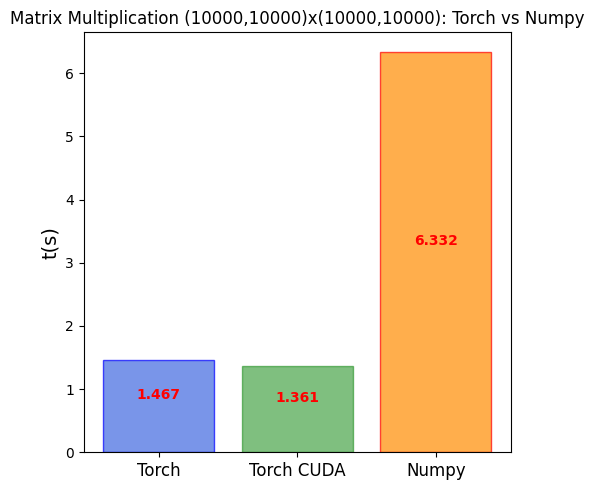

In [134]:
fig, ax = plt.subplots(figsize=(5,5))

bar1 = ax.bar(0, execution_time_torch, color="royalblue", alpha=.7, edgecolor="blue")
bar2 = ax.bar(1, execution_time_torch_cuda, color="green", alpha=.5, edgecolor="green")
bar3 = ax.bar(2, execution_time_numpy, color="darkorange", alpha=.7, edgecolor="red")

# Set the xticks positions and labels
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Torch', 'Torch CUDA', 'Numpy'], fontsize=12)

# Add annotations on top of each bar
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(bar.get_x() + bar.get_width() / 2, height/2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='red')

ax.set_title(f"Matrix Multiplication ({r},{c})x({c},{r}): Torch vs Numpy")
ax.set_ylabel("t(s)", fontsize=14)
plt.tight_layout()
plt.show()

### `torch` gradients

The main difference between torch tensors and numpy arrays lies in the fact that torch tensors can automatically keep track of **gradients**, i.e. variations in their components. This feature makes pytorch tensors particularly useful in the implementation of deep learning frameworks such as *neural networks* because they automatic differentiation can be exploited in techniques such as *backpropagation*, at the basis of neural networks training. 

Let's see how gradients are implemented in pytorch.

In [155]:
# Create a tensor with requires_grad=True to track gradients
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

In [156]:
x

tensor([1., 2., 3.], requires_grad=True)

Let define a function depending on the $x_i$ components of the above defined tensor as follows:
$$ y = \sum_i 2x_i^2 $$
The gradient components of $y$ w.r.t. to $x$ are:
$$
(\nabla y)_j \equiv \frac{\partial y}{\partial x_j} = 4x_j
$$

In [157]:
# We have:
y = (2*x**2).sum()

In [158]:
# The total value of y is:
y

tensor(28., grad_fn=<SumBackward0>)

In [159]:
# Now we compute the gradients using the .backward() method
y.backward()

In [160]:
# Finally we print the gradients that are "stored" in the x tensor object
print(f"The gradient of y w.r.t. x is: {x.grad}")

The gradient of y w.r.t. x is: tensor([ 4.,  8., 12.])


In [162]:
# Equivalent to 4x
4*x

tensor([ 4.,  8., 12.], grad_fn=<MulBackward0>)

## The Maxwell-Boltzmann Distribution: theory

## Simulation 

We are now ready to code a simulation to "prove" the Maxwell-Boltzmann distribution. In particular, our objective is to simulate the collisions between particles in a box, representing gas particle in a finite volume $V$, and look at how the distribution of their velocities changes over time. We will see that as time flows and particles keep colliding elastically between each other, their distribution smoothly approaches the Maxwell-Boltzmann distributions. To being able to simulate thousands of particles at the same time, we will work with torch tensors and exploits when possible the benefits of GPU-acceleration. 

Let's first start to simulate few particles and verify that we are correctly modeling the problem.

In [164]:
n_particles = 16

# Defining the position tensors as a 2xN tensor
r = torch.rand((2,n_particles)).to(device)

In [165]:
r.shape

torch.Size([2, 16])

`r` is torch tensor of shape 2x16. There are 2 rows which represents respectively x and y coordinates. The number of columns matches instead the number of particles. Therefore, the coordinates of the first particle are:

In [166]:
r[:,0]

tensor([0.3900, 0.3214])

For the sake of visualization, we define two different sets of indices: indices of particles arriving from the "left" of the box and indices of particles arriving from the "right". Since we have randomly assigned initial positions to particle drawing random numbers from $[0,1]$, we are implicitly confining particles in a box of size 1x1. Therefore, 

In [167]:
# Right and left particles. 
ixr = r[0]>0.5 
ixl = r[0]<=0.5 

In [168]:
ixr

tensor([False, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True, False, False, False])

`ixr` is a tensor of booleans where `True` means that the x coordinate of the particle is greater than 0.5, i.e. the particle comes from the right, while `False` means that the particle does not come from the right. Let's visualize the initial state with a scatter plot:

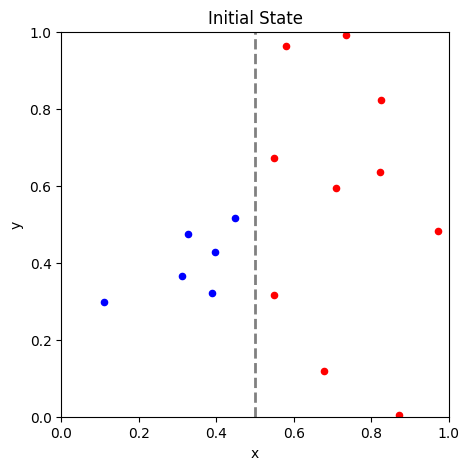

In [175]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=20)
ax.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=20)
ax.axvline(0.5, linestyle="--", color="grey", linewidth=2)

ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Initial State")
plt.show()

Now we need to define velocities. We first initialize a velocity tensor with all 0 values. Then, we assign just a $v_x$ component to all particles, setting $v_x^r = -v_x^l$, so that right and left particles can move in opposite directions.

In [176]:
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

To simplify the reference to each particle and identify in the following the colliding particles, we create a tensor of unique ids and a tensor with all possible pair combinations between particle ids.

In [178]:
ids = torch.arange(n_particles)

In [179]:
# create combintations
id_pairs = torch.combinations(ids,2).to(device)

We now need to compute the distance between all particles together since the distance will tell us whether the particles are colliding or not. We can do the computation all at once exploiting tensor algebra. The distance between particle $i$ and $j$ is:
$$
\Delta_{ij} = \sqrt{\Delta x_{ij}^2+\Delta y_{ij}^2}
$$
Let's create a tensor of x coordinates pairs:

In [188]:
id_pairs.shape

torch.Size([120, 2])

In [186]:
# first combinations : particle 0 and 1, particle 0 and 2, etc 
id_pairs[:2]

tensor([[0, 1],
        [0, 2]])

In [189]:
# The x coordinates of all particles appearing in the first column of combinations 
r[0][id_pairs[:,0]]

tensor([0.3900, 0.3900, 0.3900, 0.3900, 0.3900, 0.3900, 0.3900, 0.3900, 0.3900,
        0.3900, 0.3900, 0.3900, 0.3900, 0.3900, 0.3900, 0.3258, 0.3258, 0.3258,
        0.3258, 0.3258, 0.3258, 0.3258, 0.3258, 0.3258, 0.3258, 0.3258, 0.3258,
        0.3258, 0.3258, 0.7078, 0.7078, 0.7078, 0.7078, 0.7078, 0.7078, 0.7078,
        0.7078, 0.7078, 0.7078, 0.7078, 0.7078, 0.7078, 0.5787, 0.5787, 0.5787,
        0.5787, 0.5787, 0.5787, 0.5787, 0.5787, 0.5787, 0.5787, 0.5787, 0.5787,
        0.8219, 0.8219, 0.8219, 0.8219, 0.8219, 0.8219, 0.8219, 0.8219, 0.8219,
        0.8219, 0.8219, 0.9711, 0.9711, 0.9711, 0.9711, 0.9711, 0.9711, 0.9711,
        0.9711, 0.9711, 0.9711, 0.3110, 0.3110, 0.3110, 0.3110, 0.3110, 0.3110,
        0.3110, 0.3110, 0.3110, 0.5489, 0.5489, 0.5489, 0.5489, 0.5489, 0.5489,
        0.5489, 0.5489, 0.5482, 0.5482, 0.5482, 0.5482, 0.5482, 0.5482, 0.5482,
        0.6772, 0.6772, 0.6772, 0.6772, 0.6772, 0.6772, 0.7361, 0.7361, 0.7361,
        0.7361, 0.7361, 0.8242, 0.8242, 

In [190]:
# We stack the x coordinates of all particles in the first column of the combination with the x coordinates of all particles in the second column
# of the combination.
x_pairs = torch.stack([r[0][id_pairs[:,0]], r[0][id_pairs[:,1]]]).T

In [192]:
# A pair of x coordinates of a possible combination.
x_pairs[0]

tensor([0.3900, 0.3258])

In [193]:
x_pairs.shape

torch.Size([120, 2])

We have take the *transpose* to have a $n\times 2$ matrix where $n$ here is the number of possibile combinations. Since we have fixed above the number of particles, we also have a fixed number of possible combinations given by:

In [196]:
tot_comb = int((n_particles*(n_particles-1))/2)
tot_comb

120

In [197]:
# Same with y
y_pairs = torch.stack([r[1][id_pairs[:,0]], r[1][id_pairs[:,1]]]).T

In [198]:
# We compute the difference alogn the first axis, i.e the columns since each row is a combination
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)

In [60]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

tensor([[ 2,  5],
        [ 3, 10]])

In [61]:
v1 = v[:,ids_pairs_collide[:,0]]
v2 = v[:,ids_pairs_collide[:,1]]
r1 = r[:,ids_pairs_collide[:,0]]
r2 = r[:,ids_pairs_collide[:,1]]
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

In [85]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, ids_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = ids_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

In [86]:
N = 3000
dt = 8e-6
t_steps = 2000
v0 = 500
L = 1
r = torch.rand((2,N)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(N)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((2,N)).to(device)
v[0][ixr] = -v0
v[0][ixl] = v0
radius = 0.005
rs, vs = motion(r, v, ids_pairs, ts=t_steps, dt=dt, d_cutoff=2*radius)

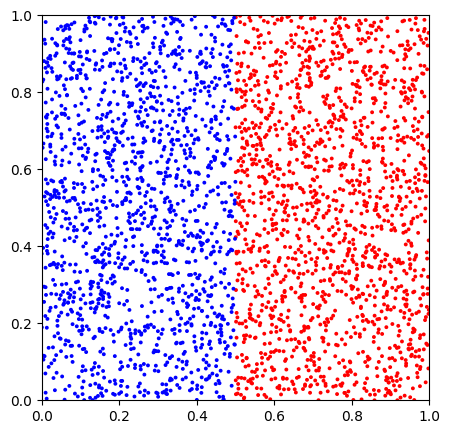

In [87]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

def animate(i):
    ax.clear()
    xred, yred = rs[i][0][ixr], rs[i][1][ixr]
    xblue, yblue = rs[i][0][ixl],rs[i][1][ixl]
    circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
    circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
    cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
    ax.add_collection(cred)
    ax.add_collection(cblue)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('ani_manypart.gif',writer='pillow',fps=30,dpi=100)

In [88]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2 / 2)

In [89]:
vs[400]

tensor([[   71.1143,   126.7921,    18.0094,  ...,  -425.6987,   374.6346,
           226.8311],
        [   71.4304, -1223.8817,    42.4450,  ...,    92.7400,   100.5029,
           -60.6644]])

In [90]:
vs[400]**2

tensor([[5.0572e+03, 1.6076e+04, 3.2434e+02,  ..., 1.8122e+05, 1.4035e+05,
         5.1452e+04],
        [5.1023e+03, 1.4979e+06, 1.8016e+03,  ..., 8.6007e+03, 1.0101e+04,
         3.6802e+03]])

Text(0, 0.5, '# Particles')

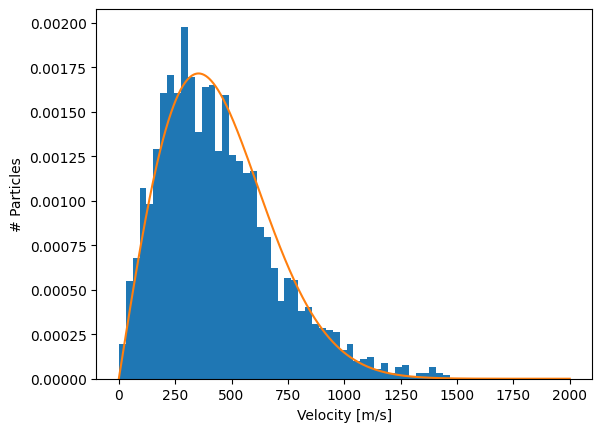

In [103]:
bins = np.linspace(0,1500,50)
plt.figure()
plt.hist(torch.sqrt(torch.sum(vs[200]**2, axis=0)), bins=bins, density=True)
plt.plot(v,fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')

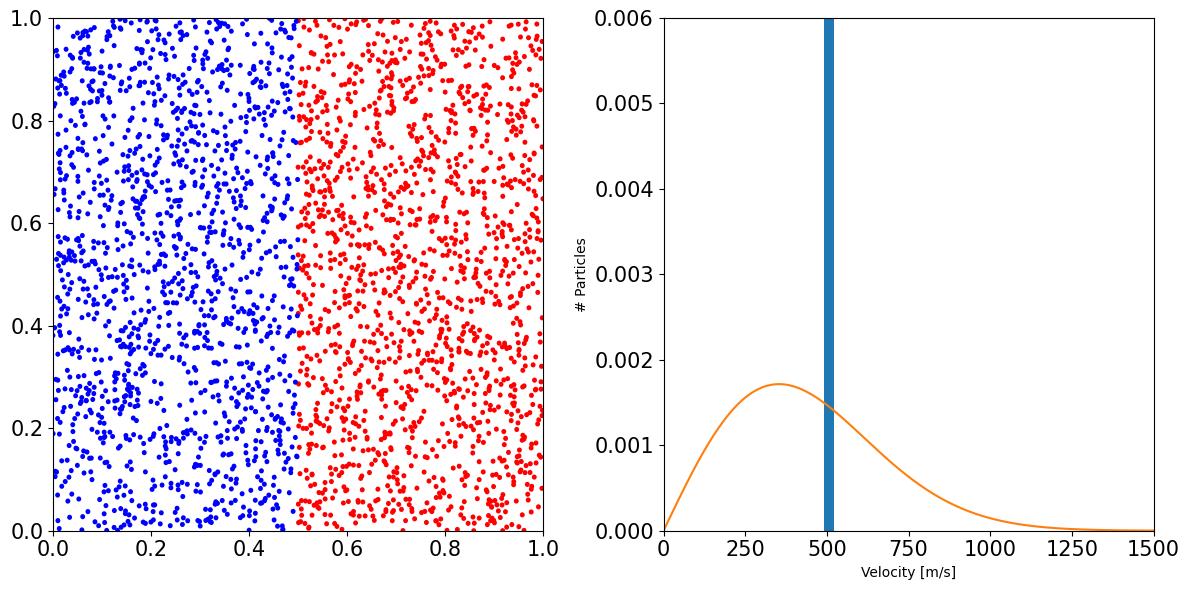

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

def animate(i):
    [ax.clear() for ax in axes]
    ax = axes[0]
    xred, yred = rs[i][0][ixr], rs[i][1][ixr]
    xblue, yblue = rs[i][0][ixl],rs[i][1][ixl]
    circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
    circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
    cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
    ax.add_collection(cred)
    ax.add_collection(cblue)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax = axes[1]
    bins = np.linspace(0,1500,50)
    ax.hist(torch.sqrt(torch.sum(vs[i]**2, axis=0)), bins=bins, density=True)
    ax.plot(v,fv)
    ax.set_xlabel('Velocity [m/s]')
    ax.set_ylabel('# Particles')
    ax.set_xlim(0,1500)
    ax.set_ylim(0,0.006)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    fig.tight_layout()
    
    
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('ani_withboltz.gif',writer='pillow',fps=30,dpi=100)